## Connection to database

In [ ]:

import pandas as pd
import psycopg2
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
import dotenv
import os

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

# Database connection parameters
import psycopg2
import os

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="allow",
)

# # Query to fetch tracking data
# query = """
# SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
# FROM player_tracking pt
# JOIN players p ON pt.player_id = p.player_id
# JOIN teams t ON p.team_id = t.team_id
# WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg';
# """
# tracking_df = pd.read_sql_query(query, conn)
# tracking_df.head()

In [ ]:
query = """
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id
    FROM spadl_actions a
    WHERE a.game_id = '5uts2s7fl98clqz8uymaazehg'
),

possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM action_changes
),

possession_groups AS (
    SELECT
        *,
        SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_id
    FROM possession_markers
),

possession_start_times AS (
    SELECT
        possession_id,
        MIN(seconds) AS possession_start_time
    FROM possession_groups
    GROUP BY possession_id
)

SELECT pg.*
FROM possession_groups pg
JOIN possession_start_times pst
ON pg.possession_id = pst.possession_id
WHERE pg.seconds - pst.possession_start_time <= 5;

"""

## Query to get all spadl action

In [8]:

def get_spadel_actions(game_id):
    query = f"""
    WITH action_changes AS (
        SELECT
            a.*,
            LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id
        FROM spadl_actions a
        WHERE a.game_id = '{game_id}'
    ),

    possession_markers AS (
        SELECT
            *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
        FROM action_changes
    ),

    possession_groups AS (
        SELECT
            *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_id
        FROM possession_markers
    ),

    possession_start_times AS (
        SELECT
            possession_id,
            MIN(seconds) AS possession_start_time
        FROM possession_groups
        GROUP BY possession_id
    )

    SELECT pg.*
    FROM possession_groups pg
    JOIN possession_start_times pst ON pg.possession_id = pst.possession_id
    WHERE pg.seconds - pst.possession_start_time <= 5;
    """
    return pd.read_sql_query(query, conn)

spadel_df = pd.read_sql_query(query, conn)
spadel_df.head()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\2290271593.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  spadel_df = pd.read_sql_query(query, conn)


,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,action_type,result,bodypart,prev_team_id,is_new_possession,possession_id
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,60gs7lod7de72ypcs6qfup8q2,8y3iucyxguipljcmf87a11bk9,52.500,34.000,43.365,36.312,0,1,0,None,1,1
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,43.365,36.312,48.720,34.680,21,1,0,8y3iucyxguipljcmf87a11bk9,0,1
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,48.720,34.680,45.150,50.184,0,1,0,8y3iucyxguipljcmf87a11bk9,0,1
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,8fs5klbsyx06c5ds9s1i3xu96,8y3iucyxguipljcmf87a11bk9,46.200,48.008,39.270,63.376,0,1,0,8y3iucyxguipljcmf87a11bk9,0,1
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,39.270,63.376,42.945,63.920,21,1,0,8y3iucyxguipljcmf87a11bk9,0,1


## Querying tracking data on players


This was not used in the end, but the beginning of this notebook was more experimental for learning, the end is more what's used

In [9]:

def get_tracking_players(game_id):
    query = f"""
    select * from player_tracking as pt
    inner join players as p on pt.player_id = p.player_id
    WHERE pt.game_id = '{game_id}'
    order by pt.timestamp asc
    """
    tracking_df = pd.read_sql_query(query, conn)
    # tracking_df["timestamp"] = pd.to_timedelta(tracking_df["timestamp"]).dt.total_seconds()
    return tracking_df

tracking_df = get_tracking_players("5uts2s7fl98clqz8uymaazehg")
tracking_df.head()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\1564932246.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tracking_df = pd.read_sql_query(query, conn)


,id,game_id,frame_id,timestamp,period_id,player_id,x,y,player_id,player_name,team_id,jersey_number
0,1834188,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,5j8jlykegiplbh3tr6zed88a1,38.161284,49.362623,5j8jlykegiplbh3tr6zed88a1,N. Rôdes,4dtif7outbuivua8umbwegoo5,18
1,1834172,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,ball,45.750820,50.091803,ball,Ball,1oyb7oym5nwzny8vxf03szd2h,0
2,1834173,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,2hr7skflmxmpiiauz04h185ey,50.377705,51.256393,2hr7skflmxmpiiauz04h185ey,B. Nsimba,4dtif7outbuivua8umbwegoo5,77
3,1834174,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,8lqo2ajhgjockasmd198nai1,27.775155,70.126555,8lqo2ajhgjockasmd198nai1,J. Pupe,4dtif7outbuivua8umbwegoo5,3
4,1834175,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,39307g4mv5kms5rtlss0x756,50.022623,65.682027,39307g4mv5kms5rtlss0x756,J. Soladio,4dtif7outbuivua8umbwegoo5,98


Converted timestamps to an identical unit, but this was not used in the end

In [10]:
import pandas as pd

# Assuming spadel_df and tracking_df are already loaded
spadel_timings = sorted(set(spadel_df['seconds'].tolist()))

# Convert tracking timestamp strings to seconds and scale by dividing by 10
tracking_df['converted_tracking_timings'] = tracking_df['timestamp'].apply(
    lambda ts: round(pd.to_timedelta(ts).total_seconds() / 10, 1)
)

# Optionally, filter so that only rows with converted timing present in spadel_timings remain.
tracking_df = tracking_df[tracking_df['converted_tracking_timings'].isin(spadel_timings)]

# Also, if needed, sort and remove duplicate converted timings (if you use them elsewhere)
converted_tracking_timings = sorted(set(tracking_df['converted_tracking_timings'].tolist()))

print(f"SPADL Timings: {spadel_timings}")
print(f"Converted Tracking Timings: {converted_tracking_timings}")


SPADL Timings: [0.0, 0.5, 1.0, 2.0, 4.0, 5.0, 7.0, 9.0, 12.0, 14.0, 15.5, 17.0, 18.0, 19.0, 23.0, 23.5, 24.0, 26.0, 27.0, 29.5, 32.0, 33.0, 33.5, 34.0, 35.0, 36.0, 38.0, 52.0, 53.0, 55.0, 60.0, 63.0, 64.0, 64.5, 65.0, 65.5, 66.0, 68.0, 68.5, 69.0, 69.5, 70.0, 73.0, 79.0, 80.0, 81.0, 90.0, 98.0, 98.5, 99.0, 99.5, 100.0, 101.5, 103.0, 104.5, 106.0, 107.0, 110.0, 113.0, 125.0, 127.5, 130.0, 133.0, 135.0, 143.0, 145.0, 146.0, 150.0, 151.0, 153.0, 154.0, 155.0, 155.5, 156.0, 157.0, 158.0, 160.0, 161.0, 164.0, 172.0, 173.0, 175.0, 184.0, 186.0, 189.0, 199.0, 200.0, 205.0, 209.0, 212.0, 213.0, 214.0, 228.0, 237.0, 240.0, 241.0, 242.5, 244.0, 245.0, 250.0, 251.0, 251.5, 252.0, 255.0, 256.0, 259.0, 260.0, 264.5, 269.0, 278.0, 279.5, 281.0, 282.0, 283.0, 285.0, 285.5, 286.0, 288.0, 290.0, 292.0, 314.0, 315.0, 316.0, 319.0, 319.5, 320.0, 320.5, 321.0, 344.0, 346.0, 347.0, 351.0, 356.0, 362.0, 364.5, 367.0, 369.0, 370.0, 372.0, 373.0, 391.0, 392.5, 394.0, 395.0, 396.0, 397.0, 399.0, 400.0, 403.0, 

Rendering all frames of all possessions for a team in a game, though this was for learning purposes, but still nice to visualize games

In [11]:
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib as mpl

# Output folder for frames
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Step 1: **Get all unique teams and assign fixed colors**
team_names = tracking_df['team_id'].unique()
fixed_colors = list(mpl.colors.TABLEAU_COLORS.values())  # 10 colors available
color_map = {team: fixed_colors[i % len(fixed_colors)] for i, team in enumerate(sorted(team_names))}

def plot_tracking_data(tracking_data, frame_id):
    """Generate and save each frame as an image with consistent team colors."""
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta', stripe=True, pitch_length=105, pitch_width=68)
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Use the precomputed converted timing value
    timestamp = tracking_data['converted_tracking_timings'].iloc[0]
    
    # Loop through each row and plot
    for _, row in tracking_data.iterrows():
        x, y = row['x'], row['y']
        team_name = row['team_id']
        
        # Plot the ball differently
        if row['player_name'] == 'Ball':
            pitch.scatter(x, y, s=90, color='yellow', ax=ax)
        else:
            pitch.scatter(x, y, s=100, color=color_map[team_name], ax=ax)
        
        # Add player names (excluding the ball)
        if row['player_name'] != 'Ball':
            ax.text(x + 2, y + 2, f"{row['player_name']} ({row['jersey_number']})", fontsize=8)
    
    ax.set_title(f'Frame {frame_id} - Timestamp: {timestamp}', fontsize=16)
    plt.tight_layout()
    
    # Save frame as PNG
    frame_filename = os.path.join(output_dir, f"frame_{frame_id}.png")
    plt.savefig(frame_filename, dpi=100)
    plt.close(fig)

# Generate frames (for example, limit to the first 200 frames)
unique_frames = tracking_df['frame_id'].unique()
for frame_id in unique_frames[:5]:
    frame_data = tracking_df[tracking_df['frame_id'] == frame_id]
    # plot_tracking_data(frame_data, frame_id)
    pass

print("Frames saved! Go create animation.")


Frames saved! Go create animation.


Another frame generater, but creates heatmaps

In [12]:
import numpy as np
import seaborn as sns

def plot_heatmap_per_frame(tracking_data, frame_id):
    """Generate and save a heatmap for each row of tracking data in a frame."""
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta', stripe=True, pitch_length=105, pitch_width=68)
    fig, ax = pitch.draw(figsize=(12, 8))

    # Use the precomputed converted timing value
    timestamp = tracking_data['converted_tracking_timings'].iloc[0]

    # Extract x, y positions for all players in the current frame
    x_positions = tracking_data['x'].values
    y_positions = tracking_data['y'].values
    
    # Create a heatmap using kernel density estimation (KDE)
    sns.kdeplot(x=x_positions, y=y_positions, shade=True, cmap="Reds", alpha=0.6, ax=ax, bw_adjust=0.5)
    
    ax.set_title(f'Heatmap {frame_id} - Timestamp: {timestamp}', fontsize=16)
    plt.tight_layout()

    # Save the heatmap frame as PNG
    heatmap_filename = os.path.join(output_dir, f"heatmap_frame_{frame_id}.png")
    plt.savefig(heatmap_filename, dpi=100)
    plt.close(fig)

# Generate heatmap for each frame (for example, limit to the first 200 frames)
unique_frames = tracking_df['frame_id'].unique()
for frame_id in unique_frames[:150]:
    frame_data = tracking_df[tracking_df['frame_id'] == frame_id]
    # plot_heatmap_per_frame(frame_data, frame_id)
    pass

print("Heatmaps saved! You can create an animation now.")


Heatmaps saved! You can create an animation now.


Here is the first actually useful query that is used throughout the project, I kept building on this query to give me all the data i could possibly need

In [13]:
def complexDfQuery(game_id, our_team, opponent_team, conn):
    complexQuery = f"""
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM public.spadl_actions a
    WHERE a.game_id = '{game_id}'
),
possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM action_changes
),
possession_groups AS (
    SELECT
        *,
        SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
    FROM possession_markers
),
possession_changes AS (
    SELECT
        *,
        CASE 
            WHEN prev_team_id = '{our_team}' AND team_id = '{opponent_team}' THEN 'A to B'
            WHEN prev_team_id = '{opponent_team}' AND team_id = '{our_team}' THEN 'B to A'
            ELSE 'No Change'
        END AS possession_change
    FROM possession_groups
),
count_rows_in_possession_group AS (
    SELECT
        *,
        COUNT(*) OVER (PARTITION BY possession_group ORDER BY period_id, seconds, id) AS rows_in_possession_group
    FROM possession_changes
),
initial_value_per_group AS (
    SELECT
        possession_group,
        MIN(seconds) AS initial_seconds
    FROM count_rows_in_possession_group
    GROUP BY possession_group
),
possession_stats AS (
    SELECT
        possession_group,
        team_id,
        COUNT(*) AS action_count,
        MAX(id) AS last_action_id
    FROM count_rows_in_possession_group
    GROUP BY possession_group, team_id
),
final_query AS (
    SELECT
        c.*, 
        (c.seconds - i.initial_seconds) AS seconds_difference,
        ABS(c.start_x - c.end_x) AS action_distance
    FROM count_rows_in_possession_group c
    JOIN initial_value_per_group i
      ON c.possession_group = i.possession_group
),
start_with_ball_table AS (
    SELECT *,
        CASE 
            WHEN FIRST_VALUE(prev_team_id) OVER (PARTITION BY possession_group ORDER BY id) IS NULL 
                 AND FIRST_VALUE(end_x) OVER (PARTITION BY possession_group ORDER BY id) < 52.5
            THEN 'LEFT_SIDE' 
            ELSE 'RIGHT_SIDE' 
        END AS start_with_ball
    FROM final_query
),
start_with_period AS (
    SELECT *,
        CASE 
            WHEN start_with_ball = 'LEFT_SIDE' AND period_id = 2 THEN 'RIGHT_SIDE' 
            WHEN start_with_ball = 'RIGHT_SIDE' AND period_id = 2 THEN 'LEFT_SIDE' 
            WHEN start_with_ball = 'LEFT_SIDE' AND period_id = 1 THEN 'LEFT_SIDE' 
            WHEN start_with_ball = 'RIGHT_SIDE' AND period_id = 1 THEN 'RIGHT_SIDE' 
        END AS update_start_with_ball
    FROM start_with_ball_table
),
isgoal AS (
    SELECT *,
        CASE 
            WHEN start_x < end_x AND update_start_with_ball = 'RIGHT_SIDE' THEN 'FORWARD'
            WHEN start_x > end_x AND update_start_with_ball = 'RIGHT_SIDE' THEN 'BACKWARD'
            WHEN start_x < end_x AND update_start_with_ball = 'LEFT_SIDE' THEN 'BACKWARD'
            WHEN start_x > end_x AND update_start_with_ball = 'LEFT_SIDE' THEN 'FORWARD'
            ELSE NULL
        END AS ballMoveDirection,
        CASE
            WHEN action_type = '10' AND result = '1' THEN '1'
            ELSE '0'
        END AS isGoal
    FROM start_with_period
    WHERE team_id = '{our_team}'
      AND possession_group IN (
          SELECT possession_group FROM possession_stats WHERE action_count >= 3
      )
),
goal_possession_groups AS (
    SELECT DISTINCT possession_group
    FROM isgoal
    WHERE isGoal = '1'
),
finale AS (
    SELECT 
        g.*,
        CASE 
            WHEN g.possession_group IN (SELECT possession_group FROM goal_possession_groups) THEN '1'
            ELSE g.isGoal
        END AS sequenceIsGoal
    FROM isgoal g
),
ballPitchPosition AS (
    SELECT d.*,
        CASE
            WHEN start_x >= 0 AND start_x < 35 THEN 'LEFT_SIDE'
            WHEN start_x >= 35 AND start_x < 70 THEN 'MIDDLE'
            WHEN start_x >= 70 AND start_x < 105 THEN 'RIGHT_SIDE'
            ELSE NULL
        END AS actionStartPitch
    FROM finale d
),
possessionGroupActionStartPitch AS (
    SELECT b.*,
           FIRST_VALUE(actionStartPitch) OVER (PARTITION BY possession_group ORDER BY id) AS possessionGroupActionStartPitch
    FROM ballPitchPosition b
),
isStartPossessionInTeamPitch AS (
    SELECT p.*,
        CASE 
            WHEN possessionGroupActionStartPitch = 'RIGHT_SIDE' AND update_start_with_ball = 'LEFT_SIDE' THEN '3'
            WHEN possessionGroupActionStartPitch = 'LEFT_SIDE' AND update_start_with_ball = 'RIGHT_SIDE' THEN '3'
            WHEN possessionGroupActionStartPitch = 'MIDDLE' THEN '2'
            WHEN possessionGroupActionStartPitch = 'RIGHT_SIDE' AND update_start_with_ball = 'RIGHT_SIDE' THEN '1'
            WHEN possessionGroupActionStartPitch = 'LEFT_SIDE' AND update_start_with_ball = 'LEFT_SIDE' THEN '1'
            ELSE NULL
        END AS isPossessionInTeamPitch
    FROM possessionGroupActionStartPitch p
)
SELECT * 
FROM isStartPossessionInTeamPitch
ORDER BY possession_group, rows_in_possession_group
"""

    return pd.read_sql_query(complexQuery, conn)

complexDf = complexDfQuery("5uts2s7fl98clqz8uymaazehg", "8y3iucyxguipljcmf87a11bk9", "4dtif7outbuivua8umbwegoo5", conn)
complexDf.to_csv('output.csv', index=False)
complexDf = complexDf.drop(columns=["start_with_ball"])
complexDf = complexDf.rename(columns={"update_start_with_ball": "start_with_ball"})

def getTeams():
    teamsQuery = """
    SELECT * FROM teams
    """
    return pd.read_sql_query(teamsQuery, conn)


teams = getTeams()

def getPlayers():
    playersQuery = """
    SELECT * FROM players
    """
    return pd.read_sql_query(playersQuery, conn)

players = getPlayers()
complexDf['player_id'] = complexDf['player_id'].replace(players.set_index('player_id')['player_name'].to_dict()) 
complexDf = complexDf.rename(columns={"player_id": "player_name"})

complexDf['team_id'] = complexDf['team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
complexDf['prev_team_id'] = complexDf['prev_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
complexDf['next_team_id'] = complexDf['next_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
complexDf = complexDf.rename(columns={"team_id": "team_name", "prev_team_id": "previous_team_name", "next_team_id": "next_team_name"})

complexDf.head(10)

,id,game_id,period_id,seconds,player_name,team_name,start_x,start_y,end_x,end_y,action_type,result,bodypart,previous_team_name,next_team_name,is_new_possession,possession_group,possession_change,rows_in_possession_group,seconds_difference,action_distance,start_with_ball,ballmovedirection,isgoal,sequenceisgoal,actionstartpitch,possessiongroupactionstartpitch,ispossessioninteampitch
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,A. Guðjohnsen,Gent,52.500,34.000,43.365,36.312,0,1,0,None,Gent,1,1,No Change,1,0.0,9.135,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,S. Kums,Gent,43.365,36.312,48.720,34.680,21,1,0,Gent,Gent,0,1,No Change,2,0.5,5.355,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,S. Kums,Gent,48.720,34.680,45.150,50.184,0,1,0,Gent,Gent,0,1,No Change,3,1.0,3.570,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,Hong Hyun-Seok,Gent,46.200,48.008,39.270,63.376,0,1,0,Gent,Gent,0,1,No Change,4,4.0,6.930,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,A. Brown,Gent,39.270,63.376,42.945,63.920,21,1,0,Gent,Gent,0,1,No Change,5,5.0,3.675,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
5,25139,5uts2s7fl98clqz8uymaazehg,1,6.0,A. Brown,Gent,42.945,63.920,28.665,51.068,0,1,0,Gent,Gent,0,1,No Change,6,6.0,14.280,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
6,25140,5uts2s7fl98clqz8uymaazehg,1,16.0,S. Mitrović,Gent,39.375,34.544,45.675,34.408,0,1,0,Gent,Gent,0,1,No Change,7,16.0,6.300,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
7,25141,5uts2s7fl98clqz8uymaazehg,1,16.5,M. Delorge,Gent,45.675,34.408,47.145,29.444,21,1,0,Gent,Gent,0,1,No Change,8,16.5,1.470,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
8,25142,5uts2s7fl98clqz8uymaazehg,1,17.0,M. Delorge,Gent,47.145,29.444,33.390,48.212,0,1,0,Gent,Gent,0,1,No Change,9,17.0,13.755,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
9,25143,5uts2s7fl98clqz8uymaazehg,1,18.0,S. Mitrović,Gent,33.390,48.212,39.480,36.720,21,1,0,Gent,Gent,0,1,No Change,10,18.0,6.090,LEFT_SIDE,BACKWARD,0,0,LEFT_SIDE,MIDDLE,2


Comparing total forward / backward passes in a game for a team, they appear quite similar and reasonable

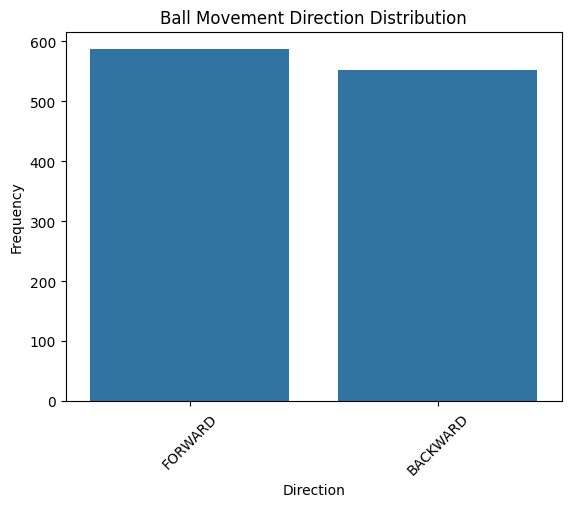

In [14]:
# Get the distribution of ball directions
ball_direction_counts = complexDf['ballmovedirection'].value_counts()

# Plot the ball direction distribution
sns.barplot(x=ball_direction_counts.index, y=ball_direction_counts.values)
plt.title('Ball Movement Direction Distribution')
plt.ylabel('Frequency')
plt.xlabel('Direction')
plt.xticks(rotation=45)
plt.show()


Time spent on each possession, gives an idea of the average tempo of the game

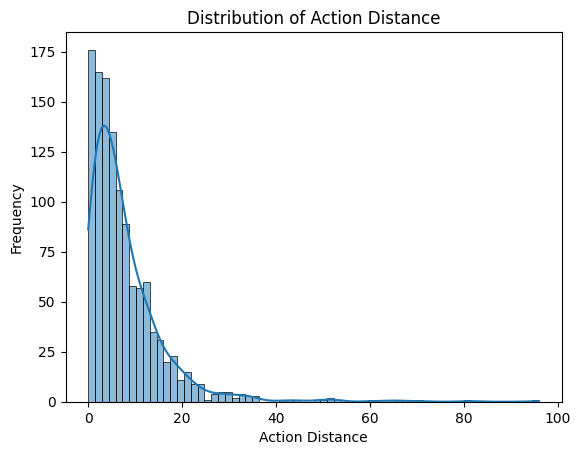

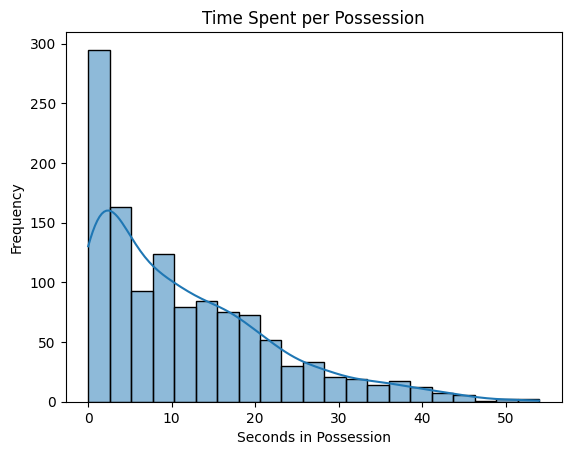

In [15]:
# Plotting action distances
sns.histplot(complexDf['action_distance'], kde=True)
plt.title('Distribution of Action Distance')
plt.xlabel('Action Distance')
plt.ylabel('Frequency')
plt.show()

# Plotting time spent in each possession group
sns.histplot(complexDf['seconds_difference'], kde=True)
plt.title('Time Spent per Possession')
plt.xlabel('Seconds in Possession')
plt.ylabel('Frequency')
plt.show()


Not relevant for my work, but I was helping someone troubleshoot their query

In [16]:

def count_passes(game_id, our_team, opponent_team, conn):
    query = f"""
    WITH action_changes AS (
        SELECT
            a.*,
            LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
            LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
        FROM
            public.spadl_actions a
        WHERE
            a.game_id = '{game_id}'  
    ),
    possession_markers AS (
        SELECT
            *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
        FROM
            action_changes
    ),
    possession_groups AS (
        SELECT
            *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
        FROM
            possession_markers
    ),
    possession_changes AS (
        SELECT
            *,
            CASE 
                WHEN prev_team_id = '{opponent_team}' AND team_id = '{our_team}' THEN 'Defence to Attack'
                WHEN prev_team_id = '{our_team}' AND team_id = '{opponent_team}' THEN 'Attack to Defence'
                ELSE 'No Change'
            END AS possession_change
        FROM
            possession_groups
    ),
    count_rows_in_possession_group AS (
        SELECT
            *,
            COUNT(*) OVER (PARTITION BY possession_group ORDER BY period_id, seconds, id) AS rows_in_possession_group
        FROM
            possession_changes
    ),
    initial_value_per_group AS (
        SELECT
            possession_group,
            MIN(seconds) AS initial_seconds
        FROM
            count_rows_in_possession_group
        GROUP BY
            possession_group
    ),
    possession_stats AS (
        SELECT
            possession_group,
            team_id,
            COUNT(*) AS action_count,
            MAX(id) AS last_action_id
        FROM
            count_rows_in_possession_group
        GROUP BY
            possession_group, team_id
    ),
    final_query AS (
        SELECT
            c.*, 
            (c.seconds - i.initial_seconds) AS seconds_difference
        FROM
            count_rows_in_possession_group c
        JOIN 
            initial_value_per_group i
        ON 
            c.possession_group = i.possession_group
    )

    SELECT count(*)
    FROM final_query
    WHERE seconds_difference <= 5 
    AND action_type IN ('0')
    AND team_id = '{our_team}'  -- to know what it's the POV
    AND possession_group IN (
        SELECT possession_group FROM possession_stats WHERE action_count >= 3
    )
    ;
    """

    
    return pd.read_sql_query(query, conn)

import pandas as pd

query = """
SELECT 
    m.match_id, 
    m.home_team_id, 
    ht.team_name AS home_team_name, 
    m.away_team_id, 
    at.team_name AS away_team_name
FROM public.matches m
JOIN public.teams ht ON m.home_team_id = ht.team_id
JOIN public.teams at ON m.away_team_id = at.team_id
ORDER BY m.match_id ASC;
"""

df = pd.read_sql_query(query, conn)

team_name_map = {
    row.home_team_id: row.home_team_name for row in df.itertuples(index=False)
}
team_name_map.update({
    row.away_team_id: row.away_team_name for row in df.itertuples(index=False)
})

team_stats = {}

for row in df.itertuples(index=False):
    match_id, home_team_id, away_team_id = row.match_id, row.home_team_id, row.away_team_id 

    home_passes = count_passes(match_id, home_team_id, away_team_id, conn)
    away_passes = count_passes(match_id, away_team_id, home_team_id, conn)

    home_team_name = team_name_map.get(home_team_id)
    away_team_name = team_name_map.get(away_team_id)

    if home_team_name not in team_stats:
        team_stats[home_team_name] = {'total_passes': 0, 'match_count': 0}
    team_stats[home_team_name]['total_passes'] += home_passes
    team_stats[home_team_name]['match_count'] += 1

    if away_team_name not in team_stats:
        team_stats[away_team_name] = {'total_passes': 0, 'match_count': 0}
    team_stats[away_team_name]['total_passes'] += away_passes
    team_stats[away_team_name]['match_count'] += 1

team_data = []
for team_name, stats in team_stats.items():
    avg_passes = stats['total_passes'] / stats['match_count']
    team_data.append((team_name, avg_passes))

average_df = pd.DataFrame(team_data, columns=['team_name', 'avg_passes'])

average_df['avg_passes'] = average_df['avg_passes'].astype(str)
average_df['avg_passes'] = average_df['avg_passes'].str.slice(start=17)

average_df.head()


average_df = average_df.sort_values(by='avg_passes', ascending=False)
average_df

,team_name,avg_passes
0,Club Brugge,158.789474
12,Sporting Charleroi,154.722222
3,Union Saint-Gilloise,146.777778
13,Antwerp,140.222222
7,Sint-Truiden,139.777778
2,Dender,136.166667
8,Genk,135.684211
1,Mechelen,133.611111
15,Cercle Brugge,133.444444
6,Anderlecht,129.210526


In [17]:

def getMatches():
    matchQuery = """
    select match_id, home_team_id, away_team_id from matches
    """
    
    return pd.read_sql_query(matchQuery, conn)

matches = getMatches()


def getMatchesList():
    matchesList = []
    for match_id, home_team_id, away_team_id in matches.itertuples(index=False):
        matchesList.append([match_id, home_team_id, away_team_id])
        # print(f"Match ID: {match_id}, Home Team ID: {home_team_id}, Away Team ID: {away_team_id}")
    print("total matches: ", len(matchesList))
    return matchesList

Per team, what is their average distance on Y axis, do they make long shots/high shots?

total matches:  146
matchesList:  [['5oc8drrbruovbuiriyhdyiyok', '1oyb7oym5nwzny8vxf03szd2h', 'b7jmo07lqav0wfe2mtlzyspak'], ['5r7lyj3frtml3aqy458jrxj4k', '920raeoumft3q2wmvc296uceo', '7zibyotq1x1hq6pmgibhr0e6s'], ['5ptnar4qtaltvcfsjdw9vzhg4', '6vyr13j6kbwdtxjwm1m4m8nu2', '2989v3kho9h5jaboe1nr7lx21'], ['5qqz2do47zjms7rfrwzcths7o', '1uk609mhtsfhokhaewjapb26', '8y3iucyxguipljcmf87a11bk9'], ['5pcyhm34h5c948yji4oryevpw', 'cyrrlv6l1onld5x247w1q1jlr', 'bw9wm8pqfzcchumhiwdt2w15c'], ['5ro450tmjg6o1r4cphzzyg74k', '2nhn3ikl1ciq34w3hcp883d6p', '3ix9om1svhd6obl0mbk1otgop'], ['5ow2wa823rjft38oh48b4ror8', '4dtif7outbuivua8umbwegoo5', 'ecj1gmc7pqcjo4sc9hvghj5u3'], ['5qa6smqwjobwdm3j0okr0r09g', '89xivtxk59uzvhdsd6miao6tm', '5z1b7fuvpqe6vnigvopomvecu'], ['5sgtiieqtx7ht2642j7ur65uc', 'b7jmo07lqav0wfe2mtlzyspak', '2nhn3ikl1ciq34w3hcp883d6p'], ['5sue6595uizdrssh0wv22egpg', 'bw9wm8pqfzcchumhiwdt2w15c', '89xivtxk59uzvhdsd6miao6tm'], ['5t7w35uh3t29uk7t0egu7q784', '2989v3kho9h5jaboe1nr7lx21', '920raeoumft3q2wm

C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\4235564153.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([longcomplexDf, combined], ignore_index=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\4235564153.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([longcomplexDf, combined], ignore_index=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\4235564153.py:14: FutureWarning: The behavior of DataFrame concatenation with empty o

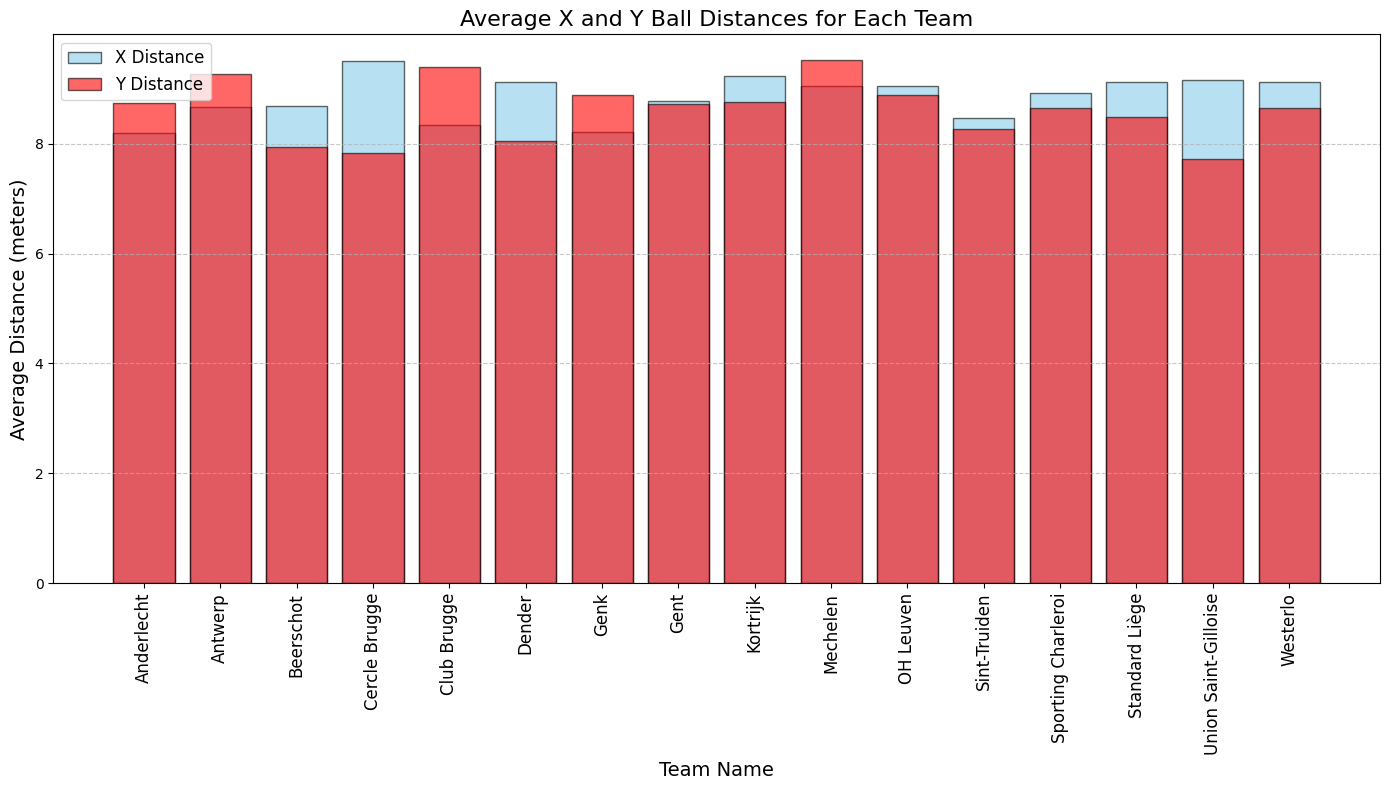

In [18]:
ballHeightShot = complexDf.copy()

matchesList = getMatchesList()
print("matchesList: ", matchesList)

# Initialize an empty DataFrame for combining results
combined = pd.DataFrame()

for match in matchesList:
    match_id, home_team_id, away_team_id = match
    longcomplexDf = complexDfQuery(match_id, home_team_id, away_team_id, conn)
    # print(f"Match ID: {match_id}, Home Team ID: {home_team_id}, Away Team ID: {away_team_id}")
    # Concatenate the new DataFrame with the combined DataFrame
    combined = pd.concat([longcomplexDf, combined], ignore_index=True)
    
# Display the first 10 rows of the combined DataFrame
players = getPlayers()
combined['player_id'] = combined['player_id'].replace(players.set_index('player_id')['player_name'].to_dict()) 
combined = combined.rename(columns={"player_id": "player_name"})

teams = getTeams()

combined['team_id'] = combined['team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined['prev_team_id'] = combined['prev_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined['next_team_id'] = combined['next_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined = combined.rename(columns={
    "team_id": "team_name", 
    "prev_team_id": "previous_team_name", 
    "next_team_id": "next_team_name"
})

combined = combined.drop(columns=["start_with_ball"])
combined = combined.rename(columns={"update_start_with_ball": "start_with_ball"})

# print(combined.head(10))
combined.to_csv('combinedOutput.csv', index=False)
combined.head()

# id,game_id,period_id,seconds,player_name,team_name,start_x,start_y,end_x,end_y,action_type,result,bodypart,previous_team_name,next_team_name,is_new_possession,possession_group,possession_change,rows_in_possession_group,seconds_difference,action_distance,start_with_ball,ballmovedirection,isgoal,sequenceisgoal,actionstartpitch,possessiongroupactionstartpitch,ispossessioninteampitch
# 240669,78nndczlbj2214zhtbfahs2s4,1,13.0,N. Sadiki,Union Saint-Gilloise,27.825000000000003,9.315999999999999,39.48,10.744,0,1,1,Club Brugge,Union Saint-Gilloise,1,4,B to A,1,0.0,11.654999999999994,RIGHT_SIDE,FORWARD,0,0,LEFT_SIDE,LEFT_SIDE,3
# 240670,78nndczlbj2214zhtbfahs2s4,1,13.5,S. Boufal,Union Saint-Gilloise,39.48,10.744,36.015,10.744,21,1,0,Union Saint-Gilloise,Union Saint-Gilloise,0,4,No Change,2,0.5,3.4649999999999963,RIGHT_SIDE,BACKWARD,0,0,MIDDLE,LEFT_SIDE,3
# 240671,78nndczlbj2214zhtbfahs2s4,1,14.0,S. Boufal,Union Saint-Gilloise,36.015,10.744,63.315,0.0,0,0,0,Union Saint-Gilloise,Club Brugge,0,4,No Change,3,1.0,27.299999999999997,RIGHT_SIDE,FORWARD,0,0,MIDDLE,LEFT_SIDE,3
# 240686,78nndczlbj2214zhtbfahs2s4,1,52.0,C. Vanhoutte,Union Saint-Gilloise,18.375,8.092,13.860000000000001,12.036,21,1,0,Club Brugge,Union Saint-Gilloise,1,12,B to A,1,0.0,4.514999999999999,RIGHT_SIDE,BACKWARD,0,0,LEFT_SIDE,LEFT_SIDE,3

# Calculate the distances for X and Y
combined['x_distance'] = abs(combined['end_x'] - combined['start_x'])
combined['y_distance'] = abs(combined['end_y'] - combined['start_y'])

# Aggregate the mean distances for each team
x_means = combined.groupby('team_name')['x_distance'].mean()
y_means = combined.groupby('team_name')['y_distance'].mean()

plt.figure(figsize=(14, 8))
plt.bar(x_means.index, x_means, label='X Distance', alpha=0.6, color='skyblue', edgecolor='black')
plt.bar(y_means.index, y_means, label='Y Distance', alpha=0.6, color='red', edgecolor='black')

plt.title('Average X and Y Ball Distances for Each Team', fontsize=16)
plt.xlabel('Team Name', fontsize=14)
plt.ylabel('Average Distance (meters)', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Generating plots giving insights into the possessions that lead to goals, how many players are usually required per team?

total matches:  146
matchesList:  [['5oc8drrbruovbuiriyhdyiyok', '1oyb7oym5nwzny8vxf03szd2h', 'b7jmo07lqav0wfe2mtlzyspak'], ['5r7lyj3frtml3aqy458jrxj4k', '920raeoumft3q2wmvc296uceo', '7zibyotq1x1hq6pmgibhr0e6s'], ['5ptnar4qtaltvcfsjdw9vzhg4', '6vyr13j6kbwdtxjwm1m4m8nu2', '2989v3kho9h5jaboe1nr7lx21'], ['5qqz2do47zjms7rfrwzcths7o', '1uk609mhtsfhokhaewjapb26', '8y3iucyxguipljcmf87a11bk9'], ['5pcyhm34h5c948yji4oryevpw', 'cyrrlv6l1onld5x247w1q1jlr', 'bw9wm8pqfzcchumhiwdt2w15c'], ['5ro450tmjg6o1r4cphzzyg74k', '2nhn3ikl1ciq34w3hcp883d6p', '3ix9om1svhd6obl0mbk1otgop'], ['5ow2wa823rjft38oh48b4ror8', '4dtif7outbuivua8umbwegoo5', 'ecj1gmc7pqcjo4sc9hvghj5u3'], ['5qa6smqwjobwdm3j0okr0r09g', '89xivtxk59uzvhdsd6miao6tm', '5z1b7fuvpqe6vnigvopomvecu'], ['5sgtiieqtx7ht2642j7ur65uc', 'b7jmo07lqav0wfe2mtlzyspak', '2nhn3ikl1ciq34w3hcp883d6p'], ['5sue6595uizdrssh0wv22egpg', 'bw9wm8pqfzcchumhiwdt2w15c', '89xivtxk59uzvhdsd6miao6tm'], ['5t7w35uh3t29uk7t0egu7q784', '2989v3kho9h5jaboe1nr7lx21', '920raeoumft3q2wm

C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\1677426927.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([longcomplexDf, combined], ignore_index=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\1677426927.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([longcomplexDf, combined], ignore_index=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\1677426927.py:14: FutureWarning: The behavior of DataFrame concatenation with empty o

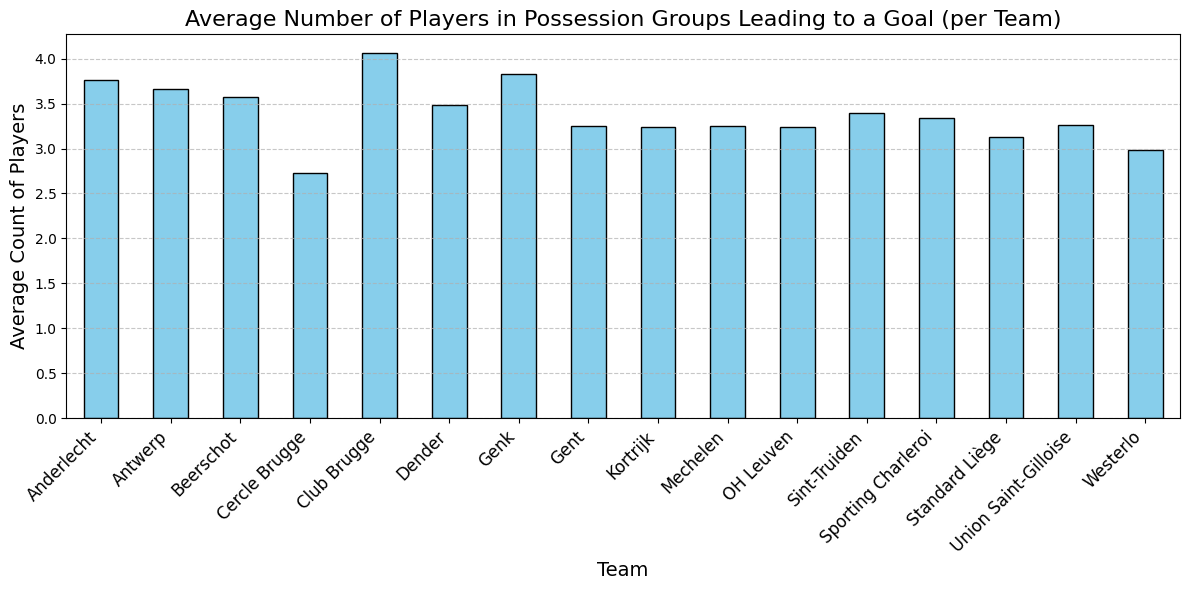

In [19]:
ballHeightShot = complexDf.copy()

matchesList = getMatchesList()
print("matchesList: ", matchesList)

# Initialize an empty DataFrame for combining results
combined = pd.DataFrame()

for match in matchesList:
    match_id, home_team_id, away_team_id = match
    longcomplexDf = complexDfQuery(match_id, home_team_id, away_team_id, conn)
    # print(f"Match ID: {match_id}, Home Team ID: {home_team_id}, Away Team ID: {away_team_id}")
    # Concatenate the new DataFrame with the combined DataFrame
    combined = pd.concat([longcomplexDf, combined], ignore_index=True)
    
# Display the first 10 rows of the combined DataFrame
players = getPlayers()
combined['player_id'] = combined['player_id'].replace(players.set_index('player_id')['player_name'].to_dict()) 
combined = combined.rename(columns={"player_id": "player_name"})

teams = getTeams()

combined['team_id'] = combined['team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined['prev_team_id'] = combined['prev_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined['next_team_id'] = combined['next_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined = combined.rename(columns={
    "team_id": "team_name", 
    "prev_team_id": "previous_team_name", 
    "next_team_id": "next_team_name"
})

combined = combined.drop(columns=["start_with_ball"])
combined = combined.rename(columns={"update_start_with_ball": "start_with_ball"})

# --- Step 1: Filter possession groups that lead to a goal ---
# We'll group by game_id, possession_group, and team_name and keep only groups that have a nonzero sequenceisgoal.
goal_possessions = combined.groupby(['game_id', 'possession_group', 'team_name'])\
    .filter(lambda x: (x['sequenceisgoal'].astype(int) > 0).any())

# --- Step 2: Count the unique players in each qualifying possession group ---
# Group by team and possession group and count unique players
grouped = goal_possessions.groupby(['team_name', 'possession_group']).agg(
    unique_players=('player_name', 'nunique')
).reset_index()

# --- Step 3: Compute the average count of unique players per team ---
avg_players = grouped.groupby('team_name')['unique_players'].mean()

# --- Step 4: Plot the results ---
plt.figure(figsize=(12, 6))
avg_players.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Number of Players in Possession Groups Leading to a Goal (per Team)", fontsize=16)
plt.xlabel("Team", fontsize=14)
plt.ylabel("Average Count of Players", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Is one side of the pitch as a starting point any easier for certain teams?

total matches:  146
matchesList:  [['5oc8drrbruovbuiriyhdyiyok', '1oyb7oym5nwzny8vxf03szd2h', 'b7jmo07lqav0wfe2mtlzyspak'], ['5r7lyj3frtml3aqy458jrxj4k', '920raeoumft3q2wmvc296uceo', '7zibyotq1x1hq6pmgibhr0e6s'], ['5ptnar4qtaltvcfsjdw9vzhg4', '6vyr13j6kbwdtxjwm1m4m8nu2', '2989v3kho9h5jaboe1nr7lx21'], ['5qqz2do47zjms7rfrwzcths7o', '1uk609mhtsfhokhaewjapb26', '8y3iucyxguipljcmf87a11bk9'], ['5pcyhm34h5c948yji4oryevpw', 'cyrrlv6l1onld5x247w1q1jlr', 'bw9wm8pqfzcchumhiwdt2w15c'], ['5ro450tmjg6o1r4cphzzyg74k', '2nhn3ikl1ciq34w3hcp883d6p', '3ix9om1svhd6obl0mbk1otgop'], ['5ow2wa823rjft38oh48b4ror8', '4dtif7outbuivua8umbwegoo5', 'ecj1gmc7pqcjo4sc9hvghj5u3'], ['5qa6smqwjobwdm3j0okr0r09g', '89xivtxk59uzvhdsd6miao6tm', '5z1b7fuvpqe6vnigvopomvecu'], ['5sgtiieqtx7ht2642j7ur65uc', 'b7jmo07lqav0wfe2mtlzyspak', '2nhn3ikl1ciq34w3hcp883d6p'], ['5sue6595uizdrssh0wv22egpg', 'bw9wm8pqfzcchumhiwdt2w15c', '89xivtxk59uzvhdsd6miao6tm'], ['5t7w35uh3t29uk7t0egu7q784', '2989v3kho9h5jaboe1nr7lx21', '920raeoumft3q2wm

C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\1217321927.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([longcomplexDf, combined], ignore_index=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\1217321927.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([longcomplexDf, combined], ignore_index=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_30092\1217321927.py:14: FutureWarning: The behavior of DataFrame concatenation with empty o

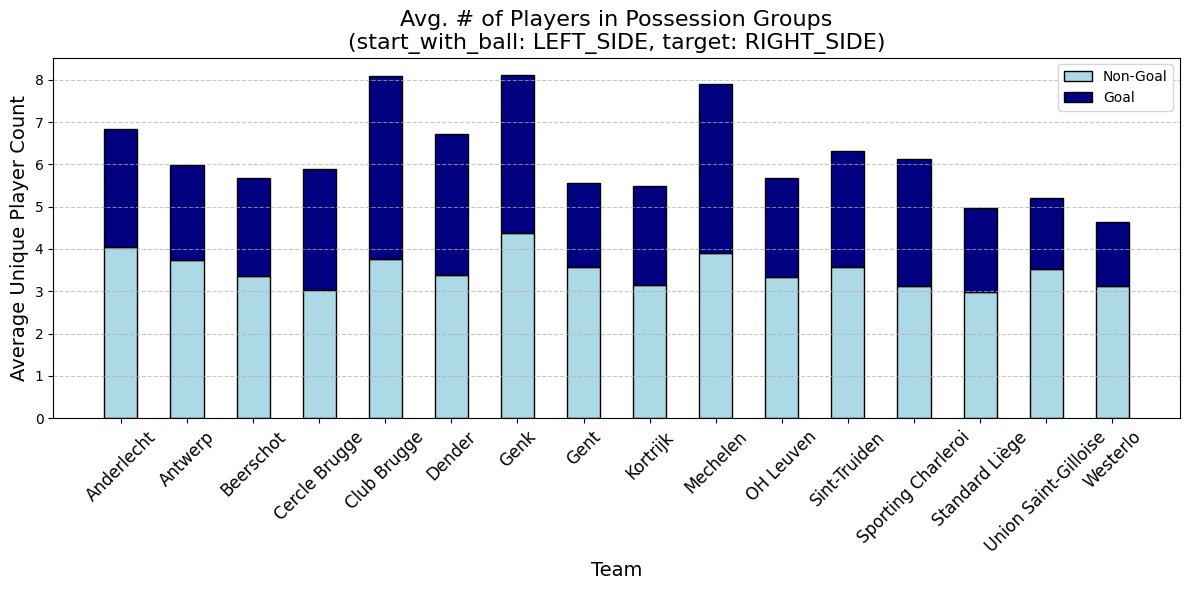

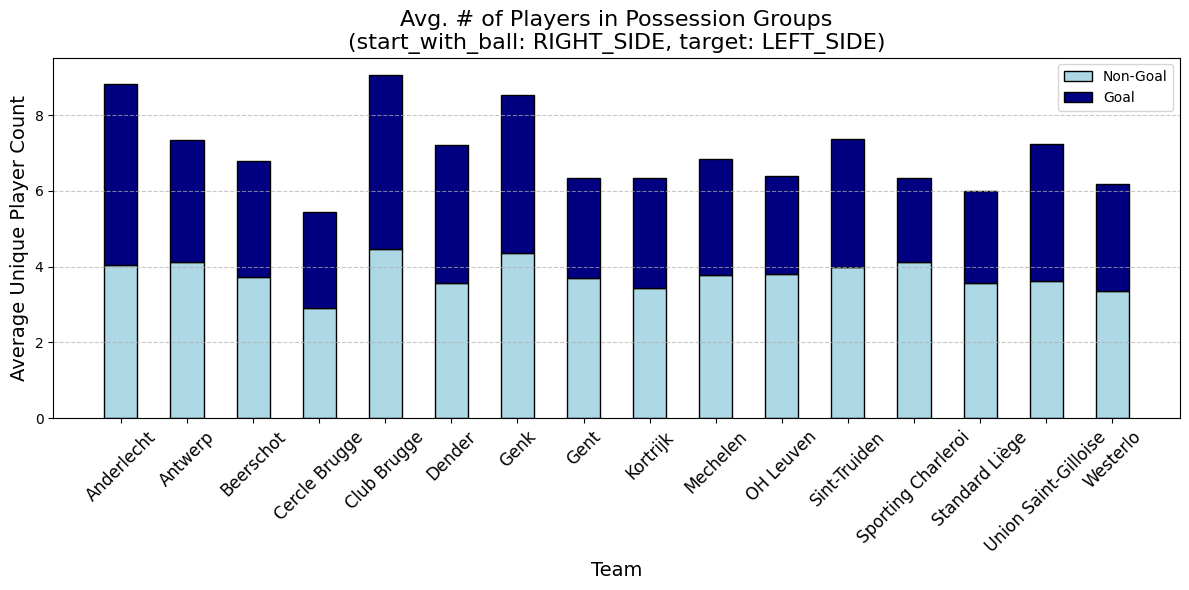

In [20]:
ballHeightShot = complexDf.copy()

matchesList = getMatchesList()
print("matchesList: ", matchesList)

# Initialize an empty DataFrame for combining results
combined = pd.DataFrame()

for match in matchesList:
    match_id, home_team_id, away_team_id = match
    longcomplexDf = complexDfQuery(match_id, home_team_id, away_team_id, conn)
    # print(f"Match ID: {match_id}, Home Team ID: {home_team_id}, Away Team ID: {away_team_id}")
    # Concatenate the new DataFrame with the combined DataFrame
    combined = pd.concat([longcomplexDf, combined], ignore_index=True)
    
# Display the first 10 rows of the combined DataFrame
players = getPlayers()
combined['player_id'] = combined['player_id'].replace(players.set_index('player_id')['player_name'].to_dict()) 
combined = combined.rename(columns={"player_id": "player_name"})

teams = getTeams()

combined['team_id'] = combined['team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined['prev_team_id'] = combined['prev_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined['next_team_id'] = combined['next_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
combined = combined.rename(columns={
    "team_id": "team_name", 
    "prev_team_id": "previous_team_name", 
    "next_team_id": "next_team_name"
})

combined = combined.drop(columns=["start_with_ball"])
combined = combined.rename(columns={"update_start_with_ball": "start_with_ball"})

def plot_for_side(start_side, target_side):
    """
    Plots a stacked bar chart for teams filtered by:
      - start_with_ball equals start_side, and
      - possessiongroupactionstartpitch equals target_side.
      
    The stacked bar shows the average unique player count in possession groups
    that did not result in a goal (bottom, light blue) and that did result in a goal (top, navy).
    """
    # Filter the DataFrame for the given conditions.
    df_filtered = combined[
        (combined['start_with_ball'] == start_side) &
        (combined['possessiongroupactionstartpitch'] == target_side)
    ]
    
    # --- Step 1: Compute unique players and goal flag for each possession group ---
    # We group by game_id, possession_group, and team_name.
    grouped = df_filtered.groupby(
        ['game_id', 'possession_group', 'team_name']
    ).agg(
        unique_players=('player_name', 'nunique'),
        goal_flag=('sequenceisgoal', lambda x: 1 if (x.astype(int) > 0).any() else 0)
    ).reset_index()

    # --- Step 2: Average unique player count per team and goal flag ---
    agg = grouped.groupby(['team_name', 'goal_flag'])['unique_players'].mean().reset_index()

    # Pivot so that for each team we have both non-goal and goal averages.
    pivot = agg.pivot_table(
        index='team_name',
        columns='goal_flag', 
        values='unique_players', 
        fill_value=0
    ).reset_index()
    
    # Rename columns: here, 0 indicates non-goal and 1 indicates goal.
    pivot = pivot.rename(columns={0: 'non_goal', 1: 'goal'})

    # --- Step 3: Plot the stacked bar chart ---
    plt.figure(figsize=(12, 6))
    teams_list = pivot['team_name']
    x = np.arange(len(teams_list))
    bar_width = 0.5

    plt.bar(x, pivot['non_goal'], width=bar_width, color='lightblue', edgecolor='black', label='Non-Goal')
    plt.bar(x, pivot['goal'], width=bar_width, bottom=pivot['non_goal'], color='navy', edgecolor='black', label='Goal')

    plt.xticks(x, teams_list, rotation=45, fontsize=12)
    plt.xlabel("Team", fontsize=14)
    plt.ylabel("Average Unique Player Count", fontsize=14)
    plt.title(f"Avg. # of Players in Possession Groups\n(start_with_ball: {start_side}, target: {target_side})", fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 1. For teams that start with the ball on the LEFT_SIDE (attacking RIGHT_SIDE)
plot_for_side('LEFT_SIDE', 'RIGHT_SIDE')

# 2. For teams that start with the ball on the RIGHT_SIDE (attacking LEFT_SIDE)
plot_for_side('RIGHT_SIDE', 'LEFT_SIDE')

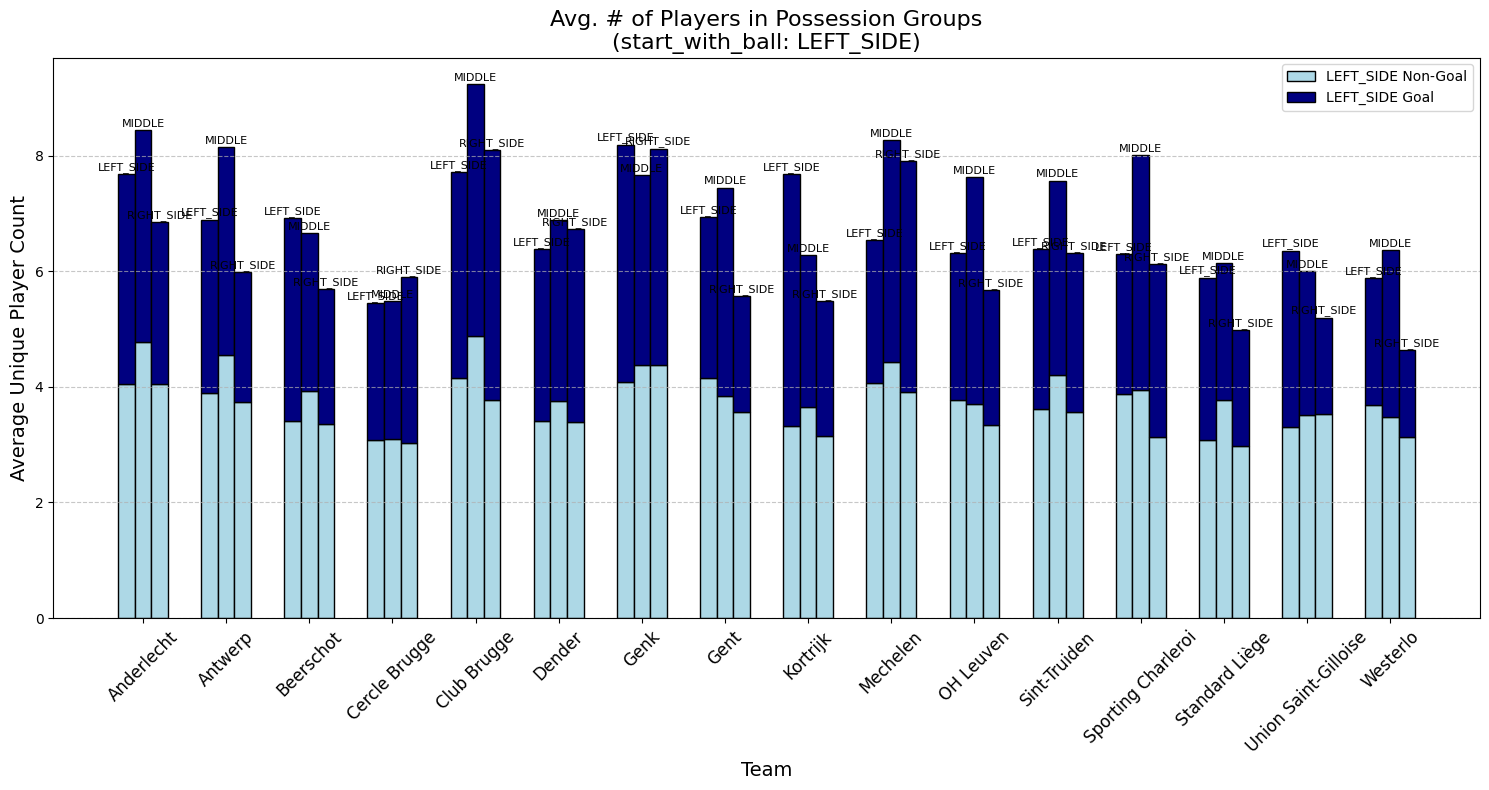

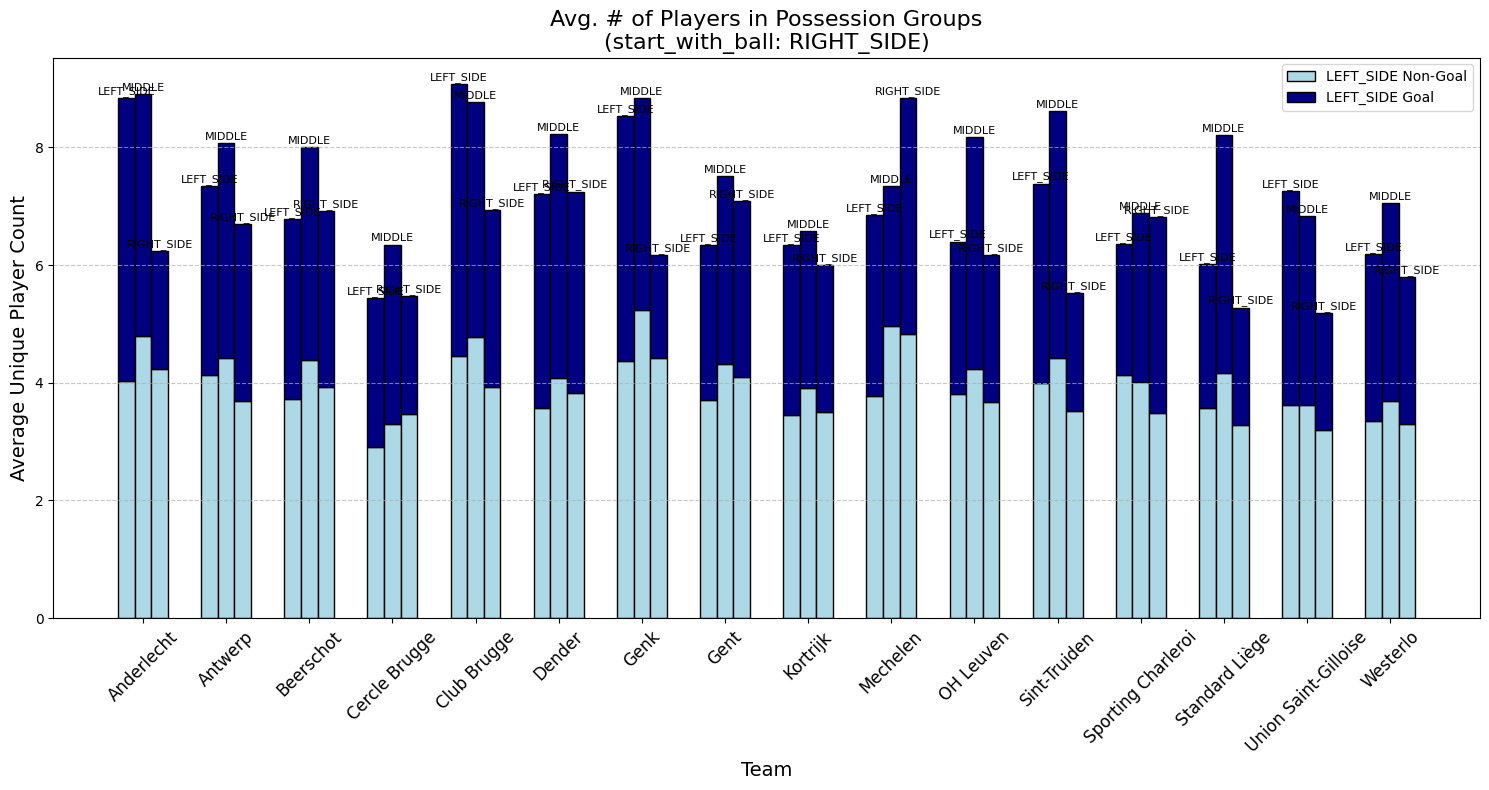

In [21]:
def plot_for_start_side(start_side):
    """
    Create a diagram for teams with a given start_with_ball side.
    Within the diagram, three towers are shown for each team corresponding to 
    possessiongroupactionstartpitch: LEFT_SIDE, MIDDLE, and RIGHT_SIDE.
    Each tower is stacked: lower segment = non-goal possessions, upper segment = goal possessions.
    """
    # Filter the DataFrame by the given start_with_ball value
    df_filtered = combined[combined['start_with_ball'] == start_side]
    
    # --- Step 1: Compute unique players and goal flag for each possession group ---
    # Group by game, possession group, team, and possession start position.
    grouped = df_filtered.groupby(
        ['game_id', 'possession_group', 'team_name', 'possessiongroupactionstartpitch']
    ).agg(
        unique_players=('player_name', 'nunique'),
        goal_flag=('sequenceisgoal', lambda x: 1 if (x.astype(int) > 0).any() else 0)
    ).reset_index()
    
    # --- Step 2: Average unique player count per team, possession start position, and goal flag ---
    agg = grouped.groupby(
        ['team_name', 'possessiongroupactionstartpitch', 'goal_flag']
    )['unique_players'].mean().reset_index()
    
    # Pivot so that for each team and possession start position we have both non-goal and goal averages.
    pivot = agg.pivot_table(
        index=['team_name', 'possessiongroupactionstartpitch'],
        columns='goal_flag', 
        values='unique_players', 
        fill_value=0
    ).reset_index()
    
    # Rename columns: here, 0 indicates non-goal and 1 indicates goal.
    pivot = pivot.rename(columns={0: 'non_goal', 1: 'goal'})
    
    # --- Step 3: Prepare data for plotting ---
    # We want three towers per team corresponding to the three pitch positions.
    pitch_positions = ['LEFT_SIDE', 'MIDDLE', 'RIGHT_SIDE']
    teams_list = sorted(pivot['team_name'].unique())
    n_teams = len(teams_list)
    bar_width = 0.2
    
    # Create x positions for the teams (each team will have its own cluster)
    x = np.arange(n_teams)
    
    plt.figure(figsize=(15, 8))
    
    # For each pitch position, get the data per team and plot the stacked bar segments.
    for i, pos in enumerate(pitch_positions):
        goal_vals = []
        non_goal_vals = []
        # For each team, get the average values for the current pitch position.
        for team in teams_list:
            row = pivot[(pivot['team_name'] == team) & (pivot['possessiongroupactionstartpitch'] == pos)]
            if not row.empty:
                non_goal_vals.append(row['non_goal'].values[0])
                goal_vals.append(row['goal'].values[0])
            else:
                non_goal_vals.append(0)
                goal_vals.append(0)
        # Calculate the x positions for this group within each team cluster.
        positions = x - bar_width + i * bar_width
        # Plot the non-goal (bottom) segment
        plt.bar(positions, non_goal_vals, width=bar_width, 
                color='lightblue', edgecolor='black',
                label=f'{pos} Non-Goal' if i == 0 else "")
        # Plot the goal (top) segment stacked on top of non-goal segment
        plt.bar(positions, goal_vals, width=bar_width, bottom=non_goal_vals, 
                color='navy', edgecolor='black',
                label=f'{pos} Goal' if i == 0 else "")
        # Optionally annotate the top of each tower with the pitch position.
        for pos_x, ng, g in zip(positions, non_goal_vals, goal_vals):
            total = ng + g
            plt.text(pos_x, total + 0.02, pos, ha='center', va='bottom', fontsize=8)
    
    # --- Step 4: Finalize the plot ---
    plt.xticks(x, teams_list, rotation=45, fontsize=12)
    plt.xlabel("Team", fontsize=14)
    plt.ylabel("Average Unique Player Count", fontsize=14)
    plt.title(f"Avg. # of Players in Possession Groups\n(start_with_ball: {start_side})", fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create two separate plots:
# 1. For teams starting with the ball on the LEFT_SIDE (presumably attacking right)
plot_for_start_side('LEFT_SIDE')

# 2. For teams starting with the ball on the RIGHT_SIDE (presumably attacking left)
plot_for_start_side('RIGHT_SIDE')